## ICU Length of stay using LightGBM Model & Tranformer  Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv
#/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/allergies.csv

In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Body_Weight,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Heart_rate,patient's_observation_of_Respiratory_rate,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_Hemoglobin_Massvolume_in_Blood,patient's_observation_of_Erythrocytes_volume_in_Blood_by_Automated_count,...,patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma,patient's_observation_of_Chloride_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Lymphocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Carbon_dioxide__total_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Neutrophils_volume_in_Blood_by_Automated_count,patient's_observation_of_Urea_nitrogen_Massvolume_in_Serum_or_Plasma,patient's most seen observation,patient_obs_count,patient_obs_count_unique
13285444,5f8a8db8-9612-41a7-be91-3f172b54fec8,0,0,196.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Heart_rate,1,1
6438593,a2a27dc5-b00e-4d71-b5a6-5cb65827fb96,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Albumin_Massvolume_in_Serum_or_Plasma,2,2
6050865,62cc838a-564f-4425-ade0-89cb75850834,0,0,0,0,0,0,37.9,0,0,...,0,0,0,0,0,0,0,Body_temperature,2,2
10856246,205e8d7c-fffc-4ddd-8e65-61cbf9fad8cc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Glomerular_filtration_rate173_sq_Mpredicted,1,1
12214473,66c30995-fbb3-4098-98b3-e0988352934a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,MCH_Entitic_mass_by_Automated_count,2,2


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 748 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [51]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Erythrocytes_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Glomerular_filtration_rate173_sq_Mpredicted",
 "patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Bilirubintotal_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count",
 "patient's_observation_of

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

## LightGBM

##### Let's start with initial LightGBM model. After seeing the feature importance plot, we will reduce features to top 40. Then we will see if it performs better with top40 features

In [55]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [56]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.4047091103579121

In [57]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.9540257342747032

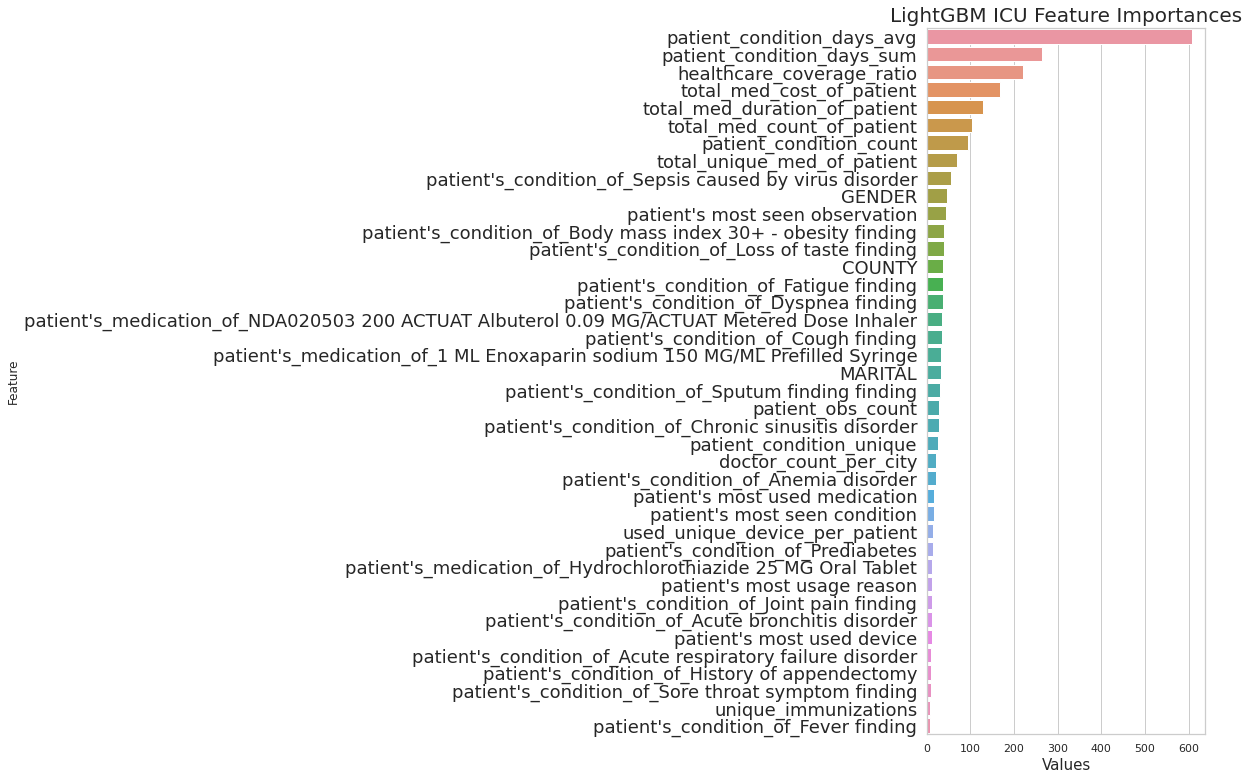

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 11))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:40])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [59]:
top40_features = feature_imp.sort_values("Value", ascending = False)[:40].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top40_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [60]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [61]:
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.4083035387569143

In [62]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.9799697919399302

#### It's indeed performing a bit better than initial model, by looking at both validation and test result we can say that

#### Let's tune some hyperparameters!

In [63]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = KFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'reg_lambda': 1.5, 'num_leaves': 4, 'num_iterations': 100, 'min_child_weight': 1, 'max_depth': 10, 'colsample_bytree': 0.7}


{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}

In [64]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Validation Result {}".format(val_result2))
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)
print("Test Result {}".format(lgb_tuned_rmse))

Validation Result 1.3823911079396343
Test Result 1.9441291440113353


In [65]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

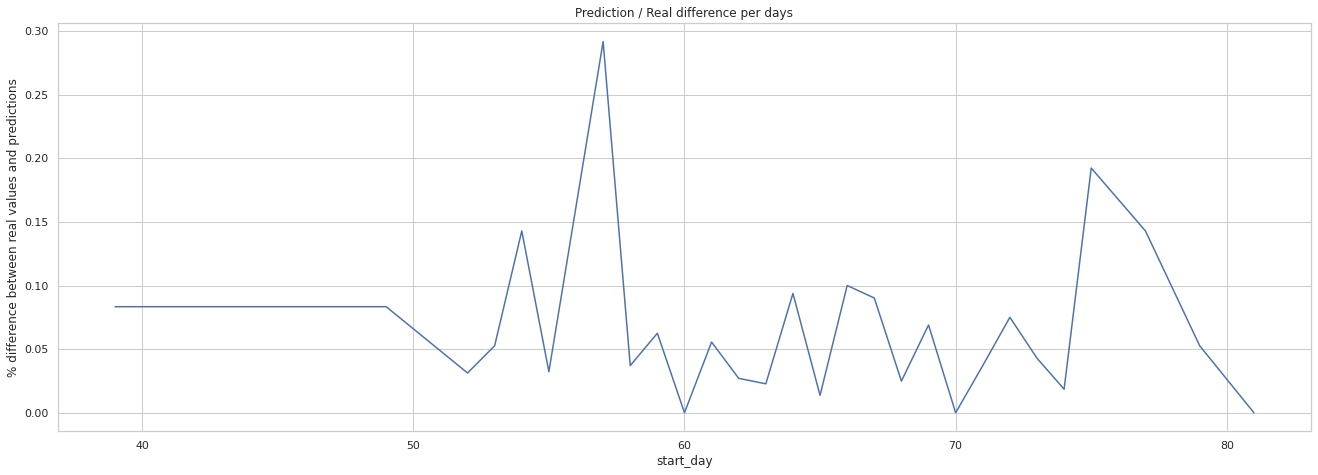

In [66]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

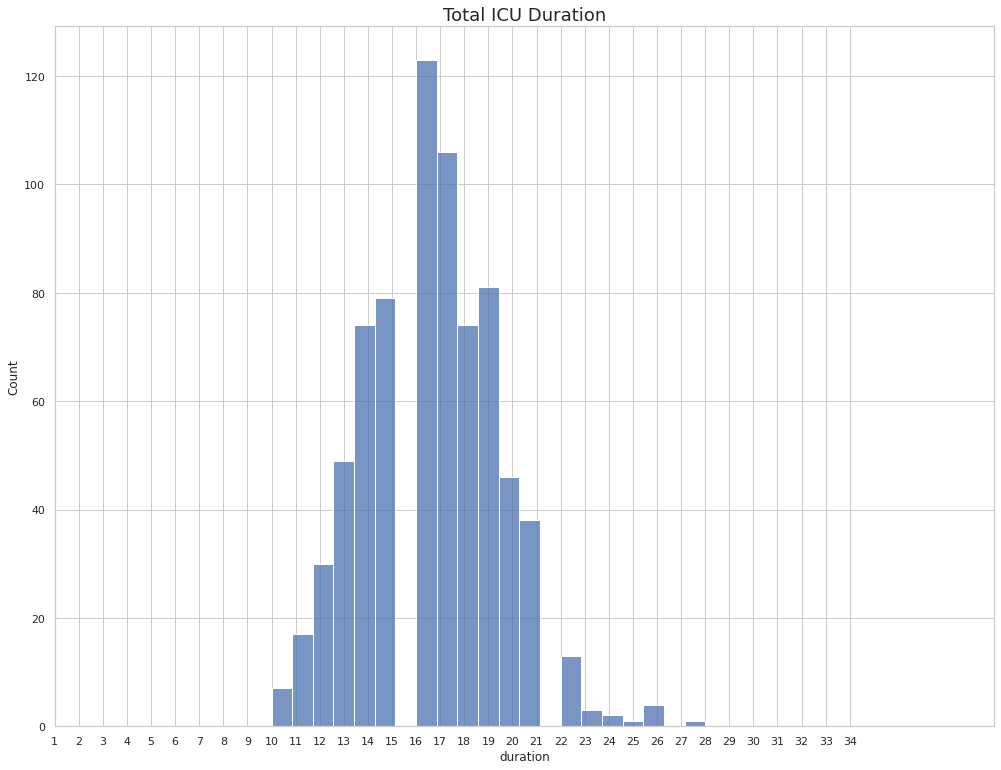

In [67]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

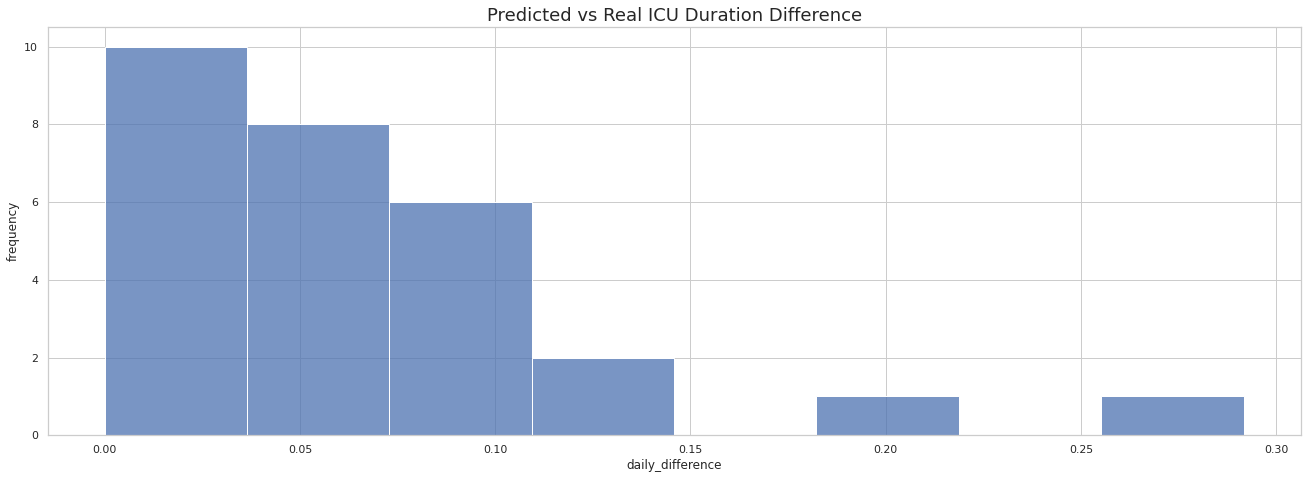

In [68]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

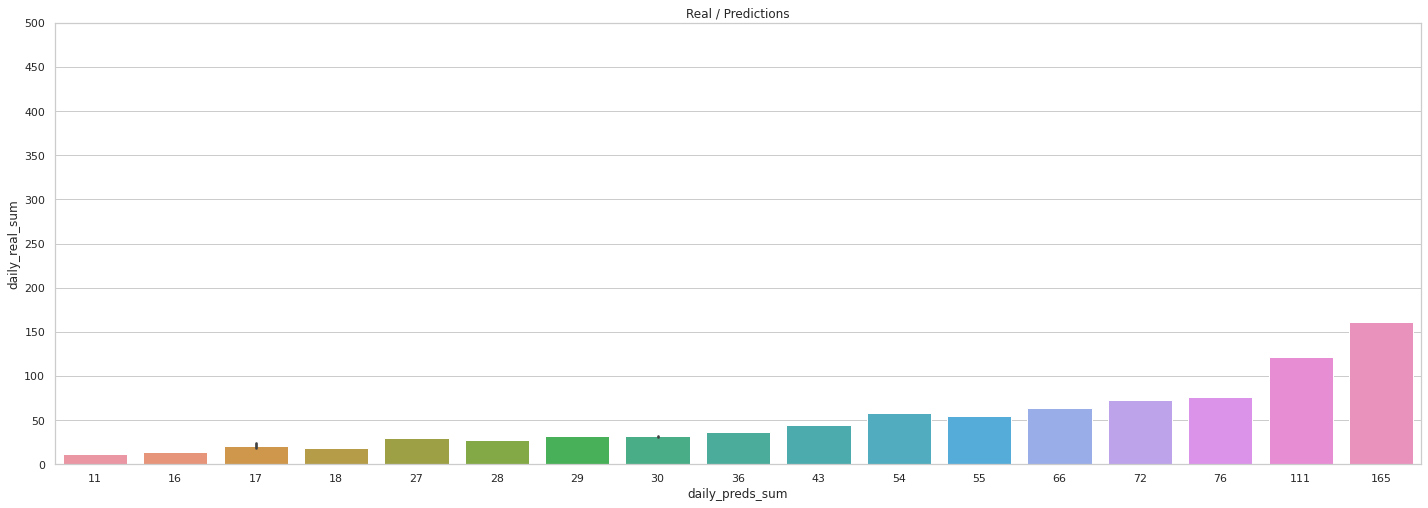

In [69]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

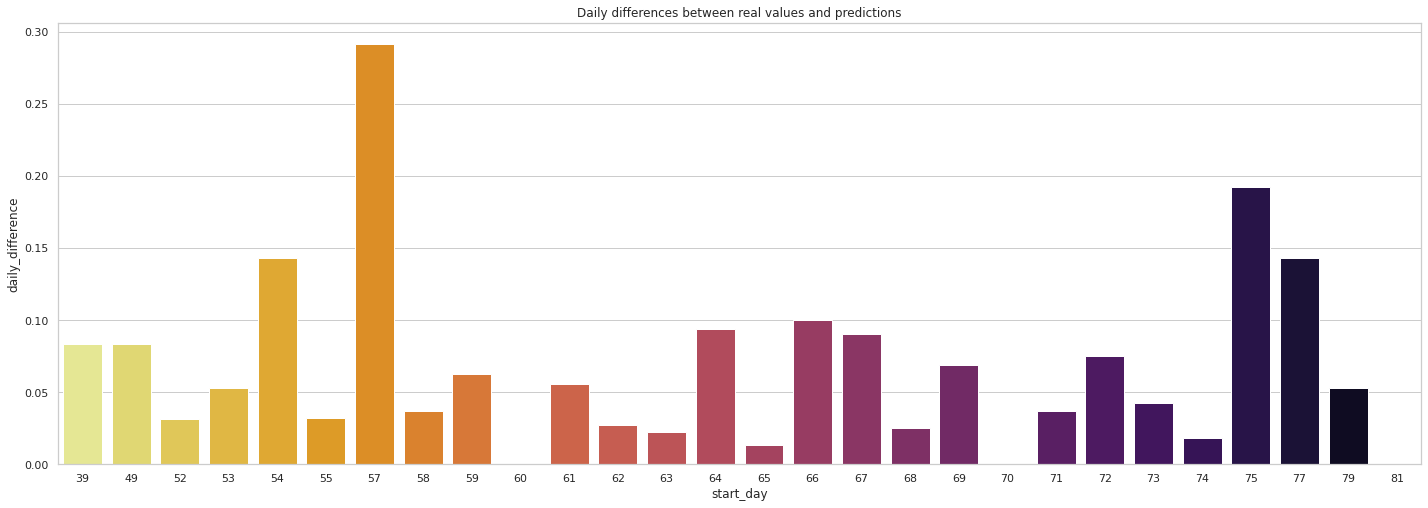

In [70]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [71]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.1 MB/s eta 0:00:00


In [72]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [74]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [75]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [76]:
y = data['duration']
LABEL = "duration"

In [77]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [78]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [79]:
CATEGORICAL_FEATURES

['GENDER',
 "patient's most seen observation",
 'COUNTY',
 'MARITAL',
 "patient's most used medication",
 "patient's most seen condition",
 "patient's most usage reason",
 "patient's most used device"]

In [80]:
NUMERIC_FEATURES

['patient_condition_days_avg',
 'patient_condition_days_sum',
 'healthcare_coverage_ratio',
 'total_med_cost_of_patient',
 'total_med_duration_of_patient',
 'total_med_count_of_patient',
 'patient_condition_count',
 'total_unique_med_of_patient',
 "patient's_condition_of_Sepsis caused by virus disorder",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_medication_of_NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler",
 "patient's_condition_of_Cough finding",
 "patient's_medication_of_1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe",
 "patient's_condition_of_Sputum finding finding",
 'patient_obs_count',
 "patient's_condition_of_Chronic sinusitis disorder",
 'patient_condition_unique',
 'doctor_count_per_city',
 "patient's_condition_of_Anemia disorder",
 'used_unique_device_per_patient',
 "patient's_conditio

In [81]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [82]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [83]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [84]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [85]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 17s 2s/step - loss: 282.5558 - output_loss: 282.5558 - output_rmse: 16.8094 - val_loss: 235.8859 - val_output_loss: 235.8859 - val_output_rmse: 15.3586
Epoch 2/150
2/2 [==============================] - 0s 108ms/step - loss: 261.7791 - output_loss: 261.7791 - output_rmse: 16.1796 - val_loss: 212.0457 - val_output_loss: 212.0457 - val_output_rmse: 14.5618
Epoch 3/150
2/2 [==============================] - 0s 97ms/step - loss: 232.1541 - output_loss: 232.1541 - output_rmse: 15.2366 - val_loss: 193.2200 - val_output_loss: 193.2200 - val_output_rmse: 13.9004
Epoch 4/150
2/2 [==============================] - 0s 175ms/step - loss: 209.3002 - output_loss: 209.3002 - output_rmse: 14.4672 - val_loss: 178.8546 - val_output_loss: 178.8546 - val_output_rmse: 13.3737
Epoch 5/150
2/2 [==============================] - 0s 131ms/step - loss: 193.3447 - output_loss: 193.3447 - output_rmse: 13.9048 - val_loss: 169.1549 - val_output_loss: 169.1549 - val

In [86]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 6s 734ms/step - loss: 279.7385 - output_loss: 279.7385 - output_rmse: 16.7254 - val_loss: 247.8754 - val_output_loss: 247.8754 - val_output_rmse: 15.7441
Epoch 2/150
2/2 [==============================] - 0s 59ms/step - loss: 270.0953 - output_loss: 270.0953 - output_rmse: 16.4346 - val_loss: 236.1559 - val_output_loss: 236.1559 - val_output_rmse: 15.3674
Epoch 3/150
2/2 [==============================] - 0s 59ms/step - loss: 260.0556 - output_loss: 260.0556 - output_rmse: 16.1262 - val_loss: 231.1853 - val_output_loss: 231.1853 - val_output_rmse: 15.2048
Epoch 4/150
2/2 [==============================] - 0s 62ms/step - loss: 251.8177 - output_loss: 251.8177 - output_rmse: 15.8688 - val_loss: 226.5106 - val_output_loss: 226.5106 - val_output_rmse: 15.0503
Epoch 5/150
2/2 [==============================] - 0s 53ms/step - loss: 244.9149 - output_loss: 244.9149 - output_rmse: 15.6498 - val_loss: 222.3010 - val_output_loss: 222.3010 - val_

In [87]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 616ms/step


In [88]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.7 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [89]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-29 00:36:53,385] A new study created in memory with name: no-name-7f09ecb2-5813-46ba-85a6-b8f139b487d7


Epoch 1/150
2/2 [==============================] - 12s 2s/step - loss: 282.3824 - output_loss: 282.3824 - output_rmse: 16.8042 - val_loss: 190.3756 - val_output_loss: 190.3756 - val_output_rmse: 13.7977
Epoch 2/150
2/2 [==============================] - 0s 241ms/step - loss: 213.3282 - output_loss: 213.3282 - output_rmse: 14.6058 - val_loss: 140.4392 - val_output_loss: 140.4392 - val_output_rmse: 11.8507
Epoch 3/150
2/2 [==============================] - 0s 182ms/step - loss: 157.0243 - output_loss: 157.0243 - output_rmse: 12.5309 - val_loss: 112.8925 - val_output_loss: 112.8925 - val_output_rmse: 10.6251
Epoch 4/150
2/2 [==============================] - 0s 171ms/step - loss: 125.6225 - output_loss: 125.6225 - output_rmse: 11.2081 - val_loss: 96.3292 - val_output_loss: 96.3292 - val_output_rmse: 9.8147
Epoch 5/150
2/2 [==============================] - 0s 219ms/step - loss: 106.3227 - output_loss: 106.3227 - output_rmse: 10.3113 - val_loss: 85.7570 - val_output_loss: 85.7570 - val_out

[I 2023-01-29 00:37:31,679] Trial 0 finished with value: 3.4093914582506777 and parameters: {'numerical_bins': 179, 'embedding_dim': 66, 'depth': 6, 'heads': 4, 'attn_dropout': 0.2587680941650643, 'ff_dropout': 0.16135720542033422}. Best is trial 0 with value: 3.4093914582506777.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 279.3425 - output_loss: 279.3425 - output_rmse: 16.7135 - val_loss: 240.1786 - val_output_loss: 240.1786 - val_output_rmse: 15.4977
Epoch 2/150
2/2 [==============================] - 0s 83ms/step - loss: 258.4955 - output_loss: 258.4955 - output_rmse: 16.0778 - val_loss: 209.2301 - val_output_loss: 209.2301 - val_output_rmse: 14.4648
Epoch 3/150
2/2 [==============================] - 0s 97ms/step - loss: 229.6467 - output_loss: 229.6467 - output_rmse: 15.1541 - val_loss: 186.1495 - val_output_loss: 186.1495 - val_output_rmse: 13.6437
Epoch 4/150
2/2 [==============================] - 0s 87ms/step - loss: 205.0258 - output_loss: 205.0258 - output_rmse: 14.3187 - val_loss: 166.2603 - val_output_loss: 166.2603 - val_output_rmse: 12.8942
Epoch 5/150
2/2 [==============================] - 0s 89ms/step - loss: 184.6379 - output_loss: 184.6379 - output_rmse: 13.5882 - val_loss: 151.7237 - val_output_loss: 151.7237 - val_out

[I 2023-01-29 00:38:05,640] Trial 1 finished with value: 3.4116885344914194 and parameters: {'numerical_bins': 198, 'embedding_dim': 17, 'depth': 6, 'heads': 2, 'attn_dropout': 0.4283734123346524, 'ff_dropout': 0.10092010287249109}. Best is trial 0 with value: 3.4093914582506777.


Epoch 1/150
2/2 [==============================] - 5s 630ms/step - loss: 282.8561 - output_loss: 282.8561 - output_rmse: 16.8183 - val_loss: 236.7894 - val_output_loss: 236.7894 - val_output_rmse: 15.3880
Epoch 2/150
2/2 [==============================] - 0s 64ms/step - loss: 263.1646 - output_loss: 263.1646 - output_rmse: 16.2224 - val_loss: 209.7436 - val_output_loss: 209.7436 - val_output_rmse: 14.4825
Epoch 3/150
2/2 [==============================] - 0s 71ms/step - loss: 233.5645 - output_loss: 233.5645 - output_rmse: 15.2828 - val_loss: 180.8535 - val_output_loss: 180.8535 - val_output_rmse: 13.4482
Epoch 4/150
2/2 [==============================] - 0s 61ms/step - loss: 205.1106 - output_loss: 205.1106 - output_rmse: 14.3217 - val_loss: 152.4515 - val_output_loss: 152.4515 - val_output_rmse: 12.3471
Epoch 5/150
2/2 [==============================] - 0s 60ms/step - loss: 177.3723 - output_loss: 177.3723 - output_rmse: 13.3181 - val_loss: 133.0869 - val_output_loss: 133.0869 - val_

1/1 [==============================] - 1s 512ms/step


[I 2023-01-29 00:38:24,915] Trial 2 finished with value: 3.40811447170958 and parameters: {'numerical_bins': 113, 'embedding_dim': 94, 'depth': 2, 'heads': 6, 'attn_dropout': 0.3401052710870517, 'ff_dropout': 0.4556646561758926}. Best is trial 2 with value: 3.40811447170958.


Epoch 1/150
2/2 [==============================] - 8s 994ms/step - loss: 281.7982 - output_loss: 281.7982 - output_rmse: 16.7868 - val_loss: 272.9833 - val_output_loss: 272.9833 - val_output_rmse: 16.5222
Epoch 2/150
2/2 [==============================] - 0s 72ms/step - loss: 280.7552 - output_loss: 280.7552 - output_rmse: 16.7557 - val_loss: 268.8465 - val_output_loss: 268.8465 - val_output_rmse: 16.3965
Epoch 3/150
2/2 [==============================] - 0s 72ms/step - loss: 277.6472 - output_loss: 277.6472 - output_rmse: 16.6627 - val_loss: 257.2688 - val_output_loss: 257.2688 - val_output_rmse: 16.0396
Epoch 4/150
2/2 [==============================] - 0s 78ms/step - loss: 271.4806 - output_loss: 271.4806 - output_rmse: 16.4767 - val_loss: 246.2434 - val_output_loss: 246.2434 - val_output_rmse: 15.6921
Epoch 5/150
2/2 [==============================] - 0s 84ms/step - loss: 265.5692 - output_loss: 265.5692 - output_rmse: 16.2963 - val_loss: 239.2591 - val_output_loss: 239.2591 - val_

1/1 [==============================] - 1s 824ms/step


[I 2023-01-29 00:38:55,995] Trial 3 finished with value: 3.4049530622389237 and parameters: {'numerical_bins': 119, 'embedding_dim': 9, 'depth': 5, 'heads': 3, 'attn_dropout': 0.33840424077715897, 'ff_dropout': 0.09297099599118425}. Best is trial 3 with value: 3.4049530622389237.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 266.1976 - output_loss: 266.1976 - output_rmse: 16.3156 - val_loss: 101.8333 - val_output_loss: 101.8333 - val_output_rmse: 10.0912
Epoch 2/150
2/2 [==============================] - 0s 97ms/step - loss: 135.4142 - output_loss: 135.4142 - output_rmse: 11.6368 - val_loss: 54.5259 - val_output_loss: 54.5259 - val_output_rmse: 7.3842
Epoch 3/150
2/2 [==============================] - 0s 98ms/step - loss: 78.2705 - output_loss: 78.2705 - output_rmse: 8.8471 - val_loss: 39.7656 - val_output_loss: 39.7656 - val_output_rmse: 6.3060
Epoch 4/150
2/2 [==============================] - 0s 100ms/step - loss: 53.2746 - output_loss: 53.2746 - output_rmse: 7.2989 - val_loss: 33.3703 - val_output_loss: 33.3703 - val_output_rmse: 5.7767
Epoch 5/150
2/2 [==============================] - 0s 104ms/step - loss: 41.4485 - output_loss: 41.4485 - output_rmse: 6.4380 - val_loss: 29.4318 - val_output_loss: 29.4318 - val_output_rmse: 5.4251
E

[I 2023-01-29 00:39:20,462] Trial 4 finished with value: 3.4142456371429337 and parameters: {'numerical_bins': 98, 'embedding_dim': 73, 'depth': 6, 'heads': 7, 'attn_dropout': 0.37407559957442155, 'ff_dropout': 0.33658011213605443}. Best is trial 3 with value: 3.4049530622389237.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 281.5709 - output_loss: 281.5709 - output_rmse: 16.7801 - val_loss: 269.0786 - val_output_loss: 269.0786 - val_output_rmse: 16.4036
Epoch 2/150
2/2 [==============================] - 0s 88ms/step - loss: 277.7637 - output_loss: 277.7637 - output_rmse: 16.6662 - val_loss: 265.4815 - val_output_loss: 265.4815 - val_output_rmse: 16.2936
Epoch 3/150
2/2 [==============================] - 0s 93ms/step - loss: 271.8961 - output_loss: 271.8961 - output_rmse: 16.4893 - val_loss: 255.7748 - val_output_loss: 255.7748 - val_output_rmse: 15.9930
Epoch 4/150
2/2 [==============================] - 0s 90ms/step - loss: 264.3642 - output_loss: 264.3642 - output_rmse: 16.2593 - val_loss: 236.3499 - val_output_loss: 236.3499 - val_output_rmse: 15.3737
Epoch 5/150
2/2 [==============================] - 0s 88ms/step - loss: 252.2578 - output_loss: 252.2578 - output_rmse: 15.8826 - val_loss: 216.9024 - val_output_loss: 216.9024 - val_out

[I 2023-01-29 00:39:59,826] Trial 5 finished with value: 3.4131355107310766 and parameters: {'numerical_bins': 151, 'embedding_dim': 10, 'depth': 6, 'heads': 8, 'attn_dropout': 0.20202477536997115, 'ff_dropout': 0.2915065135881282}. Best is trial 3 with value: 3.4049530622389237.


Epoch 1/150
2/2 [==============================] - 3s 490ms/step - loss: 281.2435 - output_loss: 281.2435 - output_rmse: 16.7703 - val_loss: 205.8895 - val_output_loss: 205.8895 - val_output_rmse: 14.3489
Epoch 2/150
2/2 [==============================] - 0s 45ms/step - loss: 233.2717 - output_loss: 233.2717 - output_rmse: 15.2732 - val_loss: 182.7268 - val_output_loss: 182.7268 - val_output_rmse: 13.5176
Epoch 3/150
2/2 [==============================] - 0s 45ms/step - loss: 208.6898 - output_loss: 208.6898 - output_rmse: 14.4461 - val_loss: 166.2626 - val_output_loss: 166.2626 - val_output_rmse: 12.8943
Epoch 4/150
2/2 [==============================] - 0s 42ms/step - loss: 191.1056 - output_loss: 191.1056 - output_rmse: 13.8241 - val_loss: 151.1831 - val_output_loss: 151.1831 - val_output_rmse: 12.2957
Epoch 5/150
2/2 [==============================] - 0s 41ms/step - loss: 175.5254 - output_loss: 175.5254 - output_rmse: 13.2486 - val_loss: 139.2094 - val_output_loss: 139.2094 - val_

[I 2023-01-29 00:40:11,674] Trial 6 finished with value: 3.408746826911902 and parameters: {'numerical_bins': 99, 'embedding_dim': 56, 'depth': 1, 'heads': 7, 'attn_dropout': 0.3930511791563373, 'ff_dropout': 0.40703918354924196}. Best is trial 3 with value: 3.4049530622389237.


Epoch 1/150
2/2 [==============================] - 8s 990ms/step - loss: 272.9624 - output_loss: 272.9624 - output_rmse: 16.5216 - val_loss: 181.3113 - val_output_loss: 181.3113 - val_output_rmse: 13.4652
Epoch 2/150
2/2 [==============================] - 0s 90ms/step - loss: 191.1593 - output_loss: 191.1593 - output_rmse: 13.8260 - val_loss: 146.3513 - val_output_loss: 146.3513 - val_output_rmse: 12.0976
Epoch 3/150
2/2 [==============================] - 0s 82ms/step - loss: 155.8494 - output_loss: 155.8494 - output_rmse: 12.4840 - val_loss: 126.2315 - val_output_loss: 126.2315 - val_output_rmse: 11.2353
Epoch 4/150
2/2 [==============================] - 0s 79ms/step - loss: 136.0335 - output_loss: 136.0335 - output_rmse: 11.6633 - val_loss: 112.7722 - val_output_loss: 112.7722 - val_output_rmse: 10.6194
Epoch 5/150
2/2 [==============================] - 0s 82ms/step - loss: 121.5541 - output_loss: 121.5541 - output_rmse: 11.0252 - val_loss: 104.1483 - val_output_loss: 104.1483 - val_

[I 2023-01-29 00:40:34,635] Trial 7 finished with value: 3.4176543760295406 and parameters: {'numerical_bins': 176, 'embedding_dim': 66, 'depth': 5, 'heads': 4, 'attn_dropout': 0.2051574021909785, 'ff_dropout': 0.06116675088055151}. Best is trial 3 with value: 3.4049530622389237.


Epoch 1/150
2/2 [==============================] - 5s 636ms/step - loss: 254.7259 - output_loss: 254.7259 - output_rmse: 15.9601 - val_loss: 139.5787 - val_output_loss: 139.5787 - val_output_rmse: 11.8143
Epoch 2/150
2/2 [==============================] - 0s 57ms/step - loss: 176.5161 - output_loss: 176.5161 - output_rmse: 13.2859 - val_loss: 103.2659 - val_output_loss: 103.2659 - val_output_rmse: 10.1620
Epoch 3/150
2/2 [==============================] - 0s 58ms/step - loss: 141.0443 - output_loss: 141.0443 - output_rmse: 11.8762 - val_loss: 77.3725 - val_output_loss: 77.3725 - val_output_rmse: 8.7962
Epoch 4/150
2/2 [==============================] - 0s 57ms/step - loss: 111.9511 - output_loss: 111.9511 - output_rmse: 10.5807 - val_loss: 60.0523 - val_output_loss: 60.0523 - val_output_rmse: 7.7493
Epoch 5/150
2/2 [==============================] - 0s 54ms/step - loss: 90.6646 - output_loss: 90.6646 - output_rmse: 9.5218 - val_loss: 47.0912 - val_output_loss: 47.0912 - val_output_rmse

[I 2023-01-29 00:40:47,572] Trial 8 finished with value: 3.41339201333302 and parameters: {'numerical_bins': 133, 'embedding_dim': 79, 'depth': 2, 'heads': 2, 'attn_dropout': 0.32618573836874803, 'ff_dropout': 0.46736063725066146}. Best is trial 3 with value: 3.4049530622389237.


Epoch 1/150
2/2 [==============================] - 3s 506ms/step - loss: 263.5199 - output_loss: 263.5199 - output_rmse: 16.2333 - val_loss: 162.5289 - val_output_loss: 162.5289 - val_output_rmse: 12.7487
Epoch 2/150
2/2 [==============================] - 0s 46ms/step - loss: 178.6061 - output_loss: 178.6061 - output_rmse: 13.3644 - val_loss: 133.3265 - val_output_loss: 133.3265 - val_output_rmse: 11.5467
Epoch 3/150
2/2 [==============================] - 0s 48ms/step - loss: 147.9901 - output_loss: 147.9901 - output_rmse: 12.1651 - val_loss: 113.3763 - val_output_loss: 113.3763 - val_output_rmse: 10.6478
Epoch 4/150
2/2 [==============================] - 0s 45ms/step - loss: 128.9334 - output_loss: 128.9334 - output_rmse: 11.3549 - val_loss: 99.1086 - val_output_loss: 99.1086 - val_output_rmse: 9.9553
Epoch 5/150
2/2 [==============================] - 0s 47ms/step - loss: 114.3254 - output_loss: 114.3254 - output_rmse: 10.6923 - val_loss: 88.6861 - val_output_loss: 88.6861 - val_outpu

[I 2023-01-29 00:40:59,818] Trial 9 finished with value: 3.3873681438856074 and parameters: {'numerical_bins': 130, 'embedding_dim': 65, 'depth': 1, 'heads': 3, 'attn_dropout': 0.37933799549343894, 'ff_dropout': 0.1365418781431983}. Best is trial 9 with value: 3.3873681438856074.


Number of finished trials: 10
Best trial: {'numerical_bins': 130, 'embedding_dim': 65, 'depth': 1, 'heads': 3, 'attn_dropout': 0.37933799549343894, 'ff_dropout': 0.1365418781431983}


In [99]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=130,
    embedding_dim=65,
    depth=1,
    heads=3,
    attn_dropout= 0.3793,
    ff_dropout= 0.1365,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 5s 480ms/step - loss: 280.4426 - output_loss: 280.4426 - output_rmse: 16.7464 - val_loss: 193.3680 - val_output_loss: 193.3680 - val_output_rmse: 13.9057
Epoch 2/250
2/2 [==============================] - 0s 47ms/step - loss: 208.6303 - output_loss: 208.6303 - output_rmse: 14.4440 - val_loss: 162.5247 - val_output_loss: 162.5247 - val_output_rmse: 12.7485
Epoch 3/250
2/2 [==============================] - 0s 54ms/step - loss: 176.9774 - output_loss: 176.9774 - output_rmse: 13.3033 - val_loss: 145.4605 - val_output_loss: 145.4605 - val_output_rmse: 12.0607
Epoch 4/250
2/2 [==============================] - 0s 46ms/step - loss: 159.5629 - output_loss: 159.5629 - output_rmse: 12.6318 - val_loss: 130.5524 - val_output_loss: 130.5524 - val_output_rmse: 11.4260
Epoch 5/250
2/2 [==============================] - 0s 42ms/step - loss: 144.3137 - output_loss: 144.3137 - output_rmse: 12.0131 - val_loss: 118.2562 - val_output_loss: 118.2562 - val_

In [91]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 380ms/step


### Periodic Encoding FT Transformer Model Graphs

In [92]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

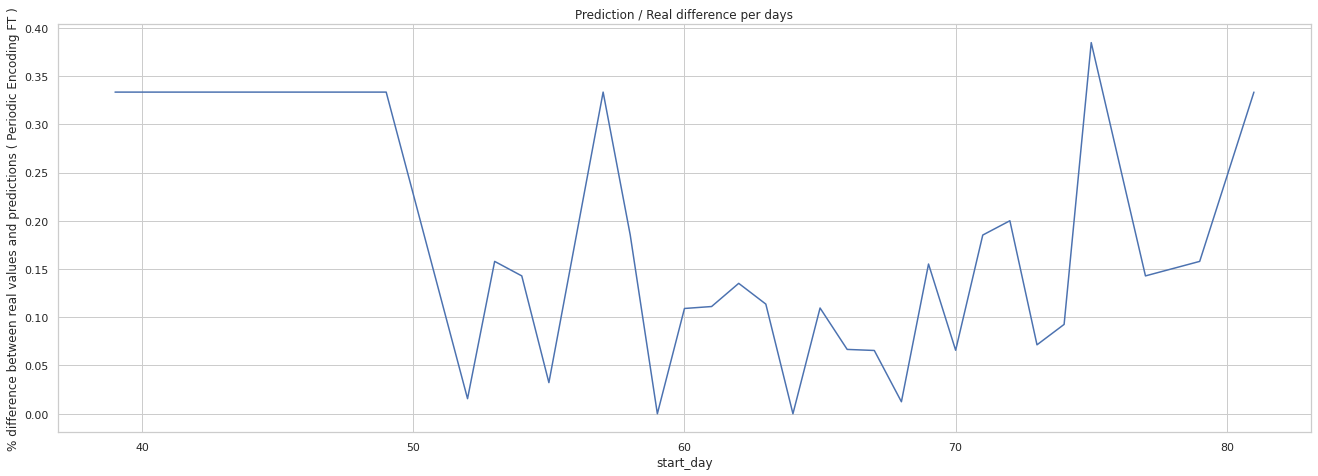

In [93]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

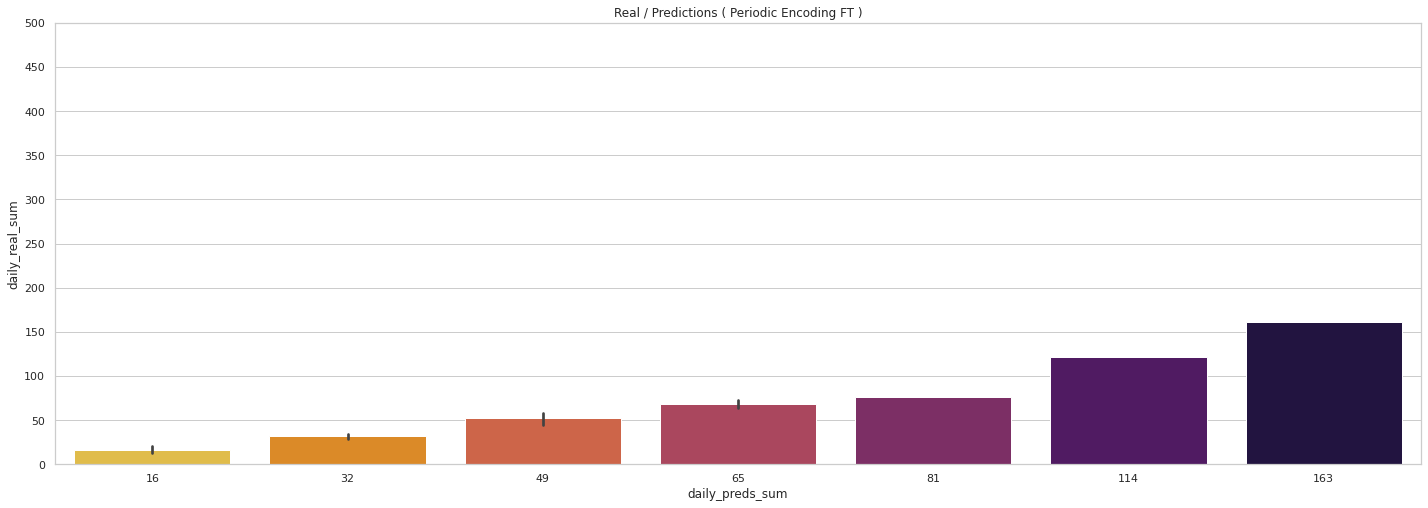

In [94]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

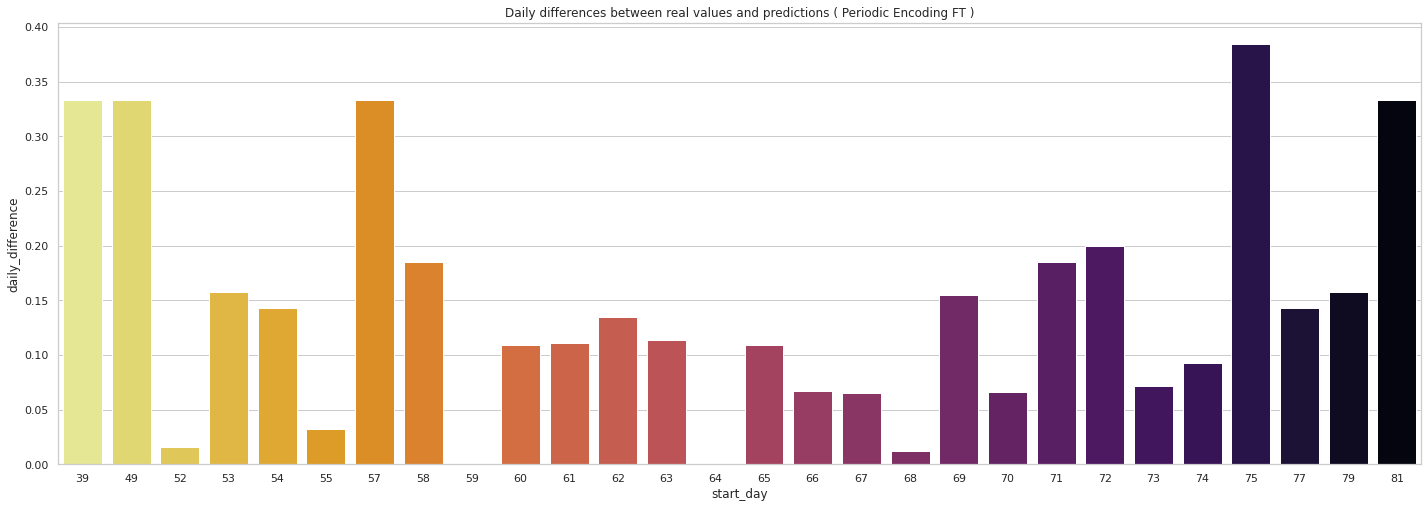

In [95]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [96]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-29 00:43:58,137] A new study created in memory with name: no-name-a1510a59-afa0-4680-8c23-2a6324498181


Epoch 1/150
2/2 [==============================] - 4s 611ms/step - loss: 281.2000 - output_loss: 281.2000 - output_rmse: 16.7690 - val_loss: 222.2925 - val_output_loss: 222.2925 - val_output_rmse: 14.9095
Epoch 2/150
2/2 [==============================] - 0s 51ms/step - loss: 234.0116 - output_loss: 234.0116 - output_rmse: 15.2974 - val_loss: 189.4029 - val_output_loss: 189.4029 - val_output_rmse: 13.7624
Epoch 3/150
2/2 [==============================] - 0s 56ms/step - loss: 201.7145 - output_loss: 201.7145 - output_rmse: 14.2026 - val_loss: 169.4738 - val_output_loss: 169.4738 - val_output_rmse: 13.0182
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 182.9590 - output_loss: 182.9590 - output_rmse: 13.5262 - val_loss: 156.7935 - val_output_loss: 156.7935 - val_output_rmse: 12.5217
Epoch 5/150
2/2 [==============================] - 0s 53ms/step - loss: 168.8989 - output_loss: 168.8989 - output_rmse: 12.9961 - val_loss: 145.1313 - val_output_loss: 145.1313 - val_

[I 2023-01-29 00:44:13,849] Trial 0 finished with value: 3.413523914969265 and parameters: {'numerical_bins': 149, 'embedding_dim': 40, 'depth': 2, 'heads': 8, 'attn_dropout': 0.3562417308880511, 'ff_dropout': 0.11097079592155867}. Best is trial 0 with value: 3.413523914969265.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 275.7330 - output_loss: 275.7330 - output_rmse: 16.6052 - val_loss: 137.3236 - val_output_loss: 137.3236 - val_output_rmse: 11.7185
Epoch 2/150
2/2 [==============================] - 0s 98ms/step - loss: 155.8545 - output_loss: 155.8545 - output_rmse: 12.4842 - val_loss: 106.4198 - val_output_loss: 106.4198 - val_output_rmse: 10.3160
Epoch 3/150
2/2 [==============================] - 0s 98ms/step - loss: 120.1326 - output_loss: 120.1326 - output_rmse: 10.9605 - val_loss: 96.3697 - val_output_loss: 96.3697 - val_output_rmse: 9.8168
Epoch 4/150
2/2 [==============================] - 0s 100ms/step - loss: 105.2594 - output_loss: 105.2594 - output_rmse: 10.2596 - val_loss: 90.3967 - val_output_loss: 90.3967 - val_output_rmse: 9.5077
Epoch 5/150
2/2 [==============================] - 0s 105ms/step - loss: 97.6652 - output_loss: 97.6652 - output_rmse: 9.8826 - val_loss: 85.7821 - val_output_loss: 85.7821 - val_output_rmse:

[I 2023-01-29 00:44:47,378] Trial 1 finished with value: 3.4203123246424094 and parameters: {'numerical_bins': 135, 'embedding_dim': 72, 'depth': 6, 'heads': 8, 'attn_dropout': 0.34155472854275926, 'ff_dropout': 0.2679616514234192}. Best is trial 0 with value: 3.413523914969265.


Epoch 1/150
2/2 [==============================] - 7s 916ms/step - loss: 250.3887 - output_loss: 250.3887 - output_rmse: 15.8237 - val_loss: 90.4530 - val_output_loss: 90.4530 - val_output_rmse: 9.5107
Epoch 2/150
2/2 [==============================] - 0s 87ms/step - loss: 115.5196 - output_loss: 115.5196 - output_rmse: 10.7480 - val_loss: 55.9336 - val_output_loss: 55.9336 - val_output_rmse: 7.4789
Epoch 3/150
2/2 [==============================] - 0s 88ms/step - loss: 71.7931 - output_loss: 71.7931 - output_rmse: 8.4731 - val_loss: 44.1165 - val_output_loss: 44.1165 - val_output_rmse: 6.6420
Epoch 4/150
2/2 [==============================] - 0s 80ms/step - loss: 53.8129 - output_loss: 53.8129 - output_rmse: 7.3357 - val_loss: 37.9487 - val_output_loss: 37.9487 - val_output_rmse: 6.1603
Epoch 5/150
2/2 [==============================] - 0s 125ms/step - loss: 44.0352 - output_loss: 44.0352 - output_rmse: 6.6359 - val_loss: 33.3558 - val_output_loss: 33.3558 - val_output_rmse: 5.7754
Ep

[I 2023-01-29 00:45:09,624] Trial 2 finished with value: 3.4088326402344915 and parameters: {'numerical_bins': 163, 'embedding_dim': 74, 'depth': 4, 'heads': 7, 'attn_dropout': 0.4988913717039461, 'ff_dropout': 0.3114108669762429}. Best is trial 2 with value: 3.4088326402344915.


Epoch 1/150
2/2 [==============================] - 8s 998ms/step - loss: 283.0303 - output_loss: 283.0303 - output_rmse: 16.8235 - val_loss: 272.8381 - val_output_loss: 272.8381 - val_output_rmse: 16.5178
Epoch 2/150
2/2 [==============================] - 0s 77ms/step - loss: 282.0931 - output_loss: 282.0931 - output_rmse: 16.7956 - val_loss: 262.7035 - val_output_loss: 262.7035 - val_output_rmse: 16.2081
Epoch 3/150
2/2 [==============================] - 0s 76ms/step - loss: 278.3323 - output_loss: 278.3323 - output_rmse: 16.6833 - val_loss: 248.1765 - val_output_loss: 248.1765 - val_output_rmse: 15.7536
Epoch 4/150
2/2 [==============================] - 0s 86ms/step - loss: 269.1055 - output_loss: 269.1055 - output_rmse: 16.4044 - val_loss: 242.3704 - val_output_loss: 242.3704 - val_output_rmse: 15.5682
Epoch 5/150
2/2 [==============================] - 0s 79ms/step - loss: 259.9380 - output_loss: 259.9380 - output_rmse: 16.1226 - val_loss: 240.3880 - val_output_loss: 240.3880 - val_

[I 2023-01-29 00:45:54,714] Trial 3 finished with value: 3.398502109989681 and parameters: {'numerical_bins': 123, 'embedding_dim': 14, 'depth': 5, 'heads': 7, 'attn_dropout': 0.29404446468019474, 'ff_dropout': 0.3792150332070715}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 7s 890ms/step - loss: 226.5638 - output_loss: 226.5638 - output_rmse: 15.0520 - val_loss: 154.5175 - val_output_loss: 154.5175 - val_output_rmse: 12.4305
Epoch 2/150
2/2 [==============================] - 0s 72ms/step - loss: 170.2274 - output_loss: 170.2274 - output_rmse: 13.0471 - val_loss: 126.6512 - val_output_loss: 126.6512 - val_output_rmse: 11.2539
Epoch 3/150
2/2 [==============================] - 0s 72ms/step - loss: 140.1272 - output_loss: 140.1272 - output_rmse: 11.8375 - val_loss: 108.1879 - val_output_loss: 108.1879 - val_output_rmse: 10.4013
Epoch 4/150
2/2 [==============================] - 0s 70ms/step - loss: 119.0161 - output_loss: 119.0161 - output_rmse: 10.9095 - val_loss: 95.8161 - val_output_loss: 95.8161 - val_output_rmse: 9.7886
Epoch 5/150
2/2 [==============================] - 0s 77ms/step - loss: 105.0164 - output_loss: 105.0164 - output_rmse: 10.2478 - val_loss: 86.1331 - val_output_loss: 86.1331 - val_outpu

[I 2023-01-29 00:46:14,042] Trial 4 finished with value: 3.4106014039168477 and parameters: {'numerical_bins': 135, 'embedding_dim': 25, 'depth': 4, 'heads': 5, 'attn_dropout': 0.44311879383461594, 'ff_dropout': 0.08716665514510835}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 7s 892ms/step - loss: 276.8661 - output_loss: 276.8661 - output_rmse: 16.6393 - val_loss: 194.4913 - val_output_loss: 194.4913 - val_output_rmse: 13.9460
Epoch 2/150
2/2 [==============================] - 0s 79ms/step - loss: 208.6310 - output_loss: 208.6310 - output_rmse: 14.4441 - val_loss: 155.8324 - val_output_loss: 155.8324 - val_output_rmse: 12.4833
Epoch 3/150
2/2 [==============================] - 0s 76ms/step - loss: 170.6996 - output_loss: 170.6996 - output_rmse: 13.0652 - val_loss: 135.0107 - val_output_loss: 135.0107 - val_output_rmse: 11.6194
Epoch 4/150
2/2 [==============================] - 0s 75ms/step - loss: 148.3614 - output_loss: 148.3614 - output_rmse: 12.1804 - val_loss: 123.9901 - val_output_loss: 123.9901 - val_output_rmse: 11.1351
Epoch 5/150
2/2 [==============================] - 0s 76ms/step - loss: 137.0681 - output_loss: 137.0681 - output_rmse: 11.7076 - val_loss: 117.8711 - val_output_loss: 117.8711 - val_

[I 2023-01-29 00:46:38,311] Trial 5 finished with value: 3.417207626877715 and parameters: {'numerical_bins': 38, 'embedding_dim': 56, 'depth': 4, 'heads': 4, 'attn_dropout': 0.35245179611443617, 'ff_dropout': 0.17432387216646944}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 3s 491ms/step - loss: 270.2653 - output_loss: 270.2653 - output_rmse: 16.4397 - val_loss: 139.9679 - val_output_loss: 139.9679 - val_output_rmse: 11.8308
Epoch 2/150
2/2 [==============================] - 0s 45ms/step - loss: 167.8384 - output_loss: 167.8384 - output_rmse: 12.9552 - val_loss: 110.1368 - val_output_loss: 110.1368 - val_output_rmse: 10.4946
Epoch 3/150
2/2 [==============================] - 0s 47ms/step - loss: 139.3047 - output_loss: 139.3047 - output_rmse: 11.8027 - val_loss: 94.9996 - val_output_loss: 94.9996 - val_output_rmse: 9.7468
Epoch 4/150
2/2 [==============================] - 0s 42ms/step - loss: 123.5079 - output_loss: 123.5079 - output_rmse: 11.1134 - val_loss: 83.0224 - val_output_loss: 83.0224 - val_output_rmse: 9.1117
Epoch 5/150
2/2 [==============================] - 0s 46ms/step - loss: 109.6144 - output_loss: 109.6144 - output_rmse: 10.4697 - val_loss: 73.9600 - val_output_loss: 73.9600 - val_output_r

[I 2023-01-29 00:46:49,008] Trial 6 finished with value: 3.4153750316331695 and parameters: {'numerical_bins': 67, 'embedding_dim': 94, 'depth': 1, 'heads': 3, 'attn_dropout': 0.04263395940703418, 'ff_dropout': 0.3164146402773768}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 7s 902ms/step - loss: 255.1015 - output_loss: 255.1015 - output_rmse: 15.9719 - val_loss: 151.2745 - val_output_loss: 151.2745 - val_output_rmse: 12.2994
Epoch 2/150
2/2 [==============================] - 0s 72ms/step - loss: 184.8874 - output_loss: 184.8874 - output_rmse: 13.5973 - val_loss: 125.3405 - val_output_loss: 125.3405 - val_output_rmse: 11.1956
Epoch 3/150
2/2 [==============================] - 0s 70ms/step - loss: 149.6028 - output_loss: 149.6028 - output_rmse: 12.2312 - val_loss: 109.8850 - val_output_loss: 109.8850 - val_output_rmse: 10.4826
Epoch 4/150
2/2 [==============================] - 0s 76ms/step - loss: 129.2613 - output_loss: 129.2613 - output_rmse: 11.3693 - val_loss: 99.8137 - val_output_loss: 99.8137 - val_output_rmse: 9.9907
Epoch 5/150
2/2 [==============================] - 0s 78ms/step - loss: 115.2128 - output_loss: 115.2128 - output_rmse: 10.7337 - val_loss: 92.5930 - val_output_loss: 92.5930 - val_outpu

[I 2023-01-29 00:47:07,154] Trial 7 finished with value: 3.4189036244781086 and parameters: {'numerical_bins': 190, 'embedding_dim': 44, 'depth': 4, 'heads': 4, 'attn_dropout': 0.33041784867881074, 'ff_dropout': 0.35996304916810956}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 8s 868ms/step - loss: 279.4484 - output_loss: 279.4484 - output_rmse: 16.7167 - val_loss: 159.6954 - val_output_loss: 159.6954 - val_output_rmse: 12.6371
Epoch 2/150
2/2 [==============================] - 0s 78ms/step - loss: 170.4444 - output_loss: 170.4444 - output_rmse: 13.0554 - val_loss: 90.6037 - val_output_loss: 90.6037 - val_output_rmse: 9.5186
Epoch 3/150
2/2 [==============================] - 0s 78ms/step - loss: 102.6206 - output_loss: 102.6206 - output_rmse: 10.1302 - val_loss: 54.5573 - val_output_loss: 54.5573 - val_output_rmse: 7.3863
Epoch 4/150
2/2 [==============================] - 0s 76ms/step - loss: 63.4323 - output_loss: 63.4323 - output_rmse: 7.9644 - val_loss: 43.3629 - val_output_loss: 43.3629 - val_output_rmse: 6.5851
Epoch 5/150
2/2 [==============================] - 0s 74ms/step - loss: 49.4475 - output_loss: 49.4475 - output_rmse: 7.0319 - val_loss: 37.2478 - val_output_loss: 37.2478 - val_output_rmse: 6.10

[I 2023-01-29 00:47:26,521] Trial 8 finished with value: 3.415587382950166 and parameters: {'numerical_bins': 136, 'embedding_dim': 72, 'depth': 4, 'heads': 5, 'attn_dropout': 0.03438915726895503, 'ff_dropout': 0.10011682204937372}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 3s 492ms/step - loss: 279.0064 - output_loss: 279.0064 - output_rmse: 16.7035 - val_loss: 218.1427 - val_output_loss: 218.1427 - val_output_rmse: 14.7697
Epoch 2/150
2/2 [==============================] - 0s 44ms/step - loss: 245.9628 - output_loss: 245.9628 - output_rmse: 15.6832 - val_loss: 197.9585 - val_output_loss: 197.9585 - val_output_rmse: 14.0698
Epoch 3/150
2/2 [==============================] - 0s 43ms/step - loss: 230.3934 - output_loss: 230.3934 - output_rmse: 15.1787 - val_loss: 190.9981 - val_output_loss: 190.9981 - val_output_rmse: 13.8202
Epoch 4/150
2/2 [==============================] - 0s 42ms/step - loss: 220.1692 - output_loss: 220.1692 - output_rmse: 14.8381 - val_loss: 184.2763 - val_output_loss: 184.2763 - val_output_rmse: 13.5748
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 210.9662 - output_loss: 210.9662 - output_rmse: 14.5247 - val_loss: 176.6496 - val_output_loss: 176.6496 - val_

[I 2023-01-29 00:47:41,712] Trial 9 finished with value: 3.411731750978601 and parameters: {'numerical_bins': 87, 'embedding_dim': 23, 'depth': 1, 'heads': 6, 'attn_dropout': 0.2900126725188957, 'ff_dropout': 0.43603139444261074}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 276.1903 - output_loss: 276.1903 - output_rmse: 16.6190 - val_loss: 233.3669 - val_output_loss: 233.3669 - val_output_rmse: 15.2764
Epoch 2/150
2/2 [==============================] - 0s 88ms/step - loss: 260.5617 - output_loss: 260.5617 - output_rmse: 16.1419 - val_loss: 219.5364 - val_output_loss: 219.5364 - val_output_rmse: 14.8168
Epoch 3/150
2/2 [==============================] - 0s 83ms/step - loss: 245.5393 - output_loss: 245.5393 - output_rmse: 15.6697 - val_loss: 207.8345 - val_output_loss: 207.8345 - val_output_rmse: 14.4165
Epoch 4/150
2/2 [==============================] - 0s 89ms/step - loss: 233.0152 - output_loss: 233.0152 - output_rmse: 15.2648 - val_loss: 197.2973 - val_output_loss: 197.2973 - val_output_rmse: 14.0463
Epoch 5/150
2/2 [==============================] - 0s 96ms/step - loss: 222.2730 - output_loss: 222.2730 - output_rmse: 14.9088 - val_loss: 189.7843 - val_output_loss: 189.7843 - val_ou

[I 2023-01-29 00:48:22,647] Trial 10 finished with value: 3.413643424589617 and parameters: {'numerical_bins': 100, 'embedding_dim': 11, 'depth': 6, 'heads': 7, 'attn_dropout': 0.2008163627929257, 'ff_dropout': 0.48557424099818036}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 8s 989ms/step - loss: 258.3810 - output_loss: 258.3810 - output_rmse: 16.0742 - val_loss: 94.8492 - val_output_loss: 94.8492 - val_output_rmse: 9.7391
Epoch 2/150
2/2 [==============================] - 0s 100ms/step - loss: 121.4990 - output_loss: 121.4990 - output_rmse: 11.0227 - val_loss: 68.3469 - val_output_loss: 68.3469 - val_output_rmse: 8.2672
Epoch 3/150
2/2 [==============================] - 0s 96ms/step - loss: 80.9285 - output_loss: 80.9285 - output_rmse: 8.9960 - val_loss: 56.8733 - val_output_loss: 56.8733 - val_output_rmse: 7.5414
Epoch 4/150
2/2 [==============================] - 0s 96ms/step - loss: 64.9205 - output_loss: 64.9205 - output_rmse: 8.0573 - val_loss: 51.0942 - val_output_loss: 51.0942 - val_output_rmse: 7.1480
Epoch 5/150
2/2 [==============================] - 0s 94ms/step - loss: 56.9272 - output_loss: 56.9272 - output_rmse: 7.5450 - val_loss: 46.6216 - val_output_loss: 46.6216 - val_output_rmse: 6.8280
Ep

[I 2023-01-29 00:48:49,635] Trial 11 finished with value: 3.4096181422378637 and parameters: {'numerical_bins': 185, 'embedding_dim': 95, 'depth': 5, 'heads': 7, 'attn_dropout': 0.47519918517506804, 'ff_dropout': 0.3824740927495357}. Best is trial 3 with value: 3.398502109989681.


Epoch 1/150
2/2 [==============================] - 6s 756ms/step - loss: 258.1307 - output_loss: 258.1307 - output_rmse: 16.0664 - val_loss: 84.1765 - val_output_loss: 84.1765 - val_output_rmse: 9.1748
Epoch 2/150
2/2 [==============================] - 0s 67ms/step - loss: 113.0747 - output_loss: 113.0747 - output_rmse: 10.6337 - val_loss: 51.7671 - val_output_loss: 51.7671 - val_output_rmse: 7.1949
Epoch 3/150
2/2 [==============================] - 0s 69ms/step - loss: 66.4531 - output_loss: 66.4531 - output_rmse: 8.1519 - val_loss: 36.7655 - val_output_loss: 36.7655 - val_output_rmse: 6.0635
Epoch 4/150
2/2 [==============================] - 0s 70ms/step - loss: 45.5877 - output_loss: 45.5877 - output_rmse: 6.7519 - val_loss: 29.2917 - val_output_loss: 29.2917 - val_output_rmse: 5.4122
Epoch 5/150
2/2 [==============================] - 0s 69ms/step - loss: 34.9868 - output_loss: 34.9868 - output_rmse: 5.9150 - val_loss: 23.9448 - val_output_loss: 23.9448 - val_output_rmse: 4.8933
Epo

[I 2023-01-29 00:49:20,023] Trial 12 finished with value: 2.1541422431577555 and parameters: {'numerical_bins': 169, 'embedding_dim': 72, 'depth': 3, 'heads': 7, 'attn_dropout': 0.4797600308933798, 'ff_dropout': 0.270073650348315}. Best is trial 12 with value: 2.1541422431577555.


Epoch 1/150
2/2 [==============================] - 6s 736ms/step - loss: 281.4879 - output_loss: 281.4879 - output_rmse: 16.7776 - val_loss: 170.7453 - val_output_loss: 170.7453 - val_output_rmse: 13.0670
Epoch 2/150
2/2 [==============================] - 0s 71ms/step - loss: 194.1984 - output_loss: 194.1984 - output_rmse: 13.9355 - val_loss: 132.5737 - val_output_loss: 132.5737 - val_output_rmse: 11.5141
Epoch 3/150
2/2 [==============================] - 0s 70ms/step - loss: 148.7283 - output_loss: 148.7283 - output_rmse: 12.1954 - val_loss: 113.9990 - val_output_loss: 113.9990 - val_output_rmse: 10.6770
Epoch 4/150
2/2 [==============================] - 0s 71ms/step - loss: 125.9727 - output_loss: 125.9727 - output_rmse: 11.2238 - val_loss: 102.4140 - val_output_loss: 102.4140 - val_output_rmse: 10.1200
Epoch 5/150
2/2 [==============================] - 0s 66ms/step - loss: 112.9602 - output_loss: 112.9602 - output_rmse: 10.6283 - val_loss: 95.4052 - val_output_loss: 95.4052 - val_ou

[I 2023-01-29 00:49:40,945] Trial 13 finished with value: 3.4149394309023813 and parameters: {'numerical_bins': 169, 'embedding_dim': 57, 'depth': 3, 'heads': 6, 'attn_dropout': 0.4221838181053115, 'ff_dropout': 0.2208367423023509}. Best is trial 12 with value: 2.1541422431577555.


Epoch 1/150
2/2 [==============================] - 6s 768ms/step - loss: 277.1450 - output_loss: 277.1450 - output_rmse: 16.6477 - val_loss: 123.3805 - val_output_loss: 123.3805 - val_output_rmse: 11.1077
Epoch 2/150
2/2 [==============================] - 0s 73ms/step - loss: 129.0455 - output_loss: 129.0455 - output_rmse: 11.3598 - val_loss: 70.4178 - val_output_loss: 70.4178 - val_output_rmse: 8.3915
Epoch 3/150
2/2 [==============================] - 0s 70ms/step - loss: 74.3082 - output_loss: 74.3082 - output_rmse: 8.6202 - val_loss: 48.9635 - val_output_loss: 48.9635 - val_output_rmse: 6.9974
Epoch 4/150
2/2 [==============================] - 0s 69ms/step - loss: 52.2131 - output_loss: 52.2131 - output_rmse: 7.2259 - val_loss: 39.4393 - val_output_loss: 39.4393 - val_output_rmse: 6.2801
Epoch 5/150
2/2 [==============================] - 0s 65ms/step - loss: 42.1506 - output_loss: 42.1506 - output_rmse: 6.4924 - val_loss: 33.4619 - val_output_loss: 33.4619 - val_output_rmse: 5.7846


[I 2023-01-29 00:50:00,148] Trial 14 finished with value: 3.4129472806705023 and parameters: {'numerical_bins': 110, 'embedding_dim': 79, 'depth': 3, 'heads': 6, 'attn_dropout': 0.21297222913402514, 'ff_dropout': 0.014087686827037704}. Best is trial 12 with value: 2.1541422431577555.


Number of finished trials: 15
Best trial: {'numerical_bins': 169, 'embedding_dim': 72, 'depth': 3, 'heads': 7, 'attn_dropout': 0.4797600308933798, 'ff_dropout': 0.270073650348315}


In [97]:
study.best_trial.params

{'numerical_bins': 169,
 'embedding_dim': 72,
 'depth': 3,
 'heads': 7,
 'attn_dropout': 0.4797600308933798,
 'ff_dropout': 0.270073650348315}

In [98]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=169,
    embedding_dim=72,
    depth=3,
    heads=7,
    attn_dropout= 0.4797,
    ff_dropout= 0.27007,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 6s 720ms/step - loss: 273.4770 - output_loss: 273.4770 - output_rmse: 16.5371 - val_loss: 107.5466 - val_output_loss: 107.5466 - val_output_rmse: 10.3705
Epoch 2/250
2/2 [==============================] - 0s 65ms/step - loss: 136.4151 - output_loss: 136.4151 - output_rmse: 11.6797 - val_loss: 66.5118 - val_output_loss: 66.5118 - val_output_rmse: 8.1555
Epoch 3/250
2/2 [==============================] - 0s 63ms/step - loss: 83.4395 - output_loss: 83.4395 - output_rmse: 9.1345 - val_loss: 48.4909 - val_output_loss: 48.4909 - val_output_rmse: 6.9635
Epoch 4/250
2/2 [==============================] - 0s 64ms/step - loss: 59.5027 - output_loss: 59.5027 - output_rmse: 7.7138 - val_loss: 39.7590 - val_output_loss: 39.7590 - val_output_rmse: 6.3055
Epoch 5/250
2/2 [==============================] - 0s 61ms/step - loss: 47.4978 - output_loss: 47.4978 - output_rmse: 6.8919 - val_loss: 34.3446 - val_output_loss: 34.3446 - val_output_rmse: 5.8604


In [100]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 613ms/step


In [101]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 21ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

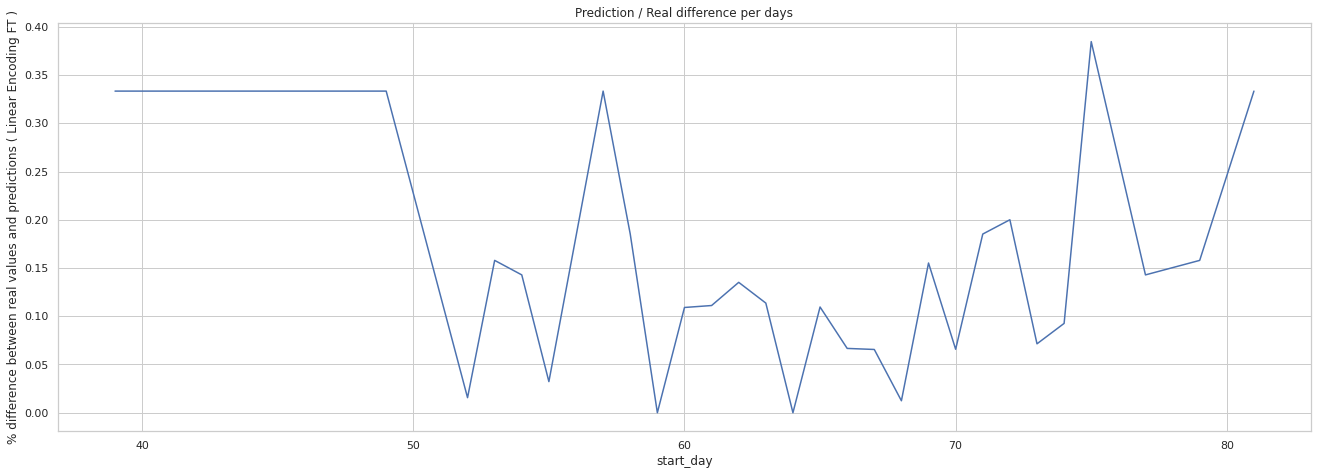

In [102]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

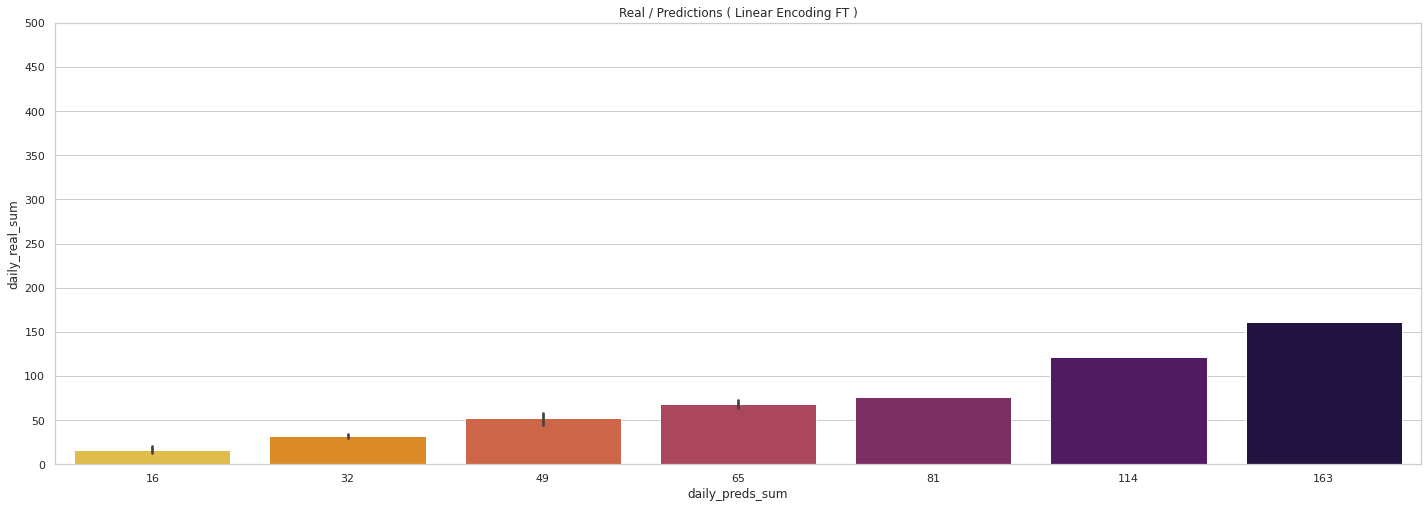

In [103]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

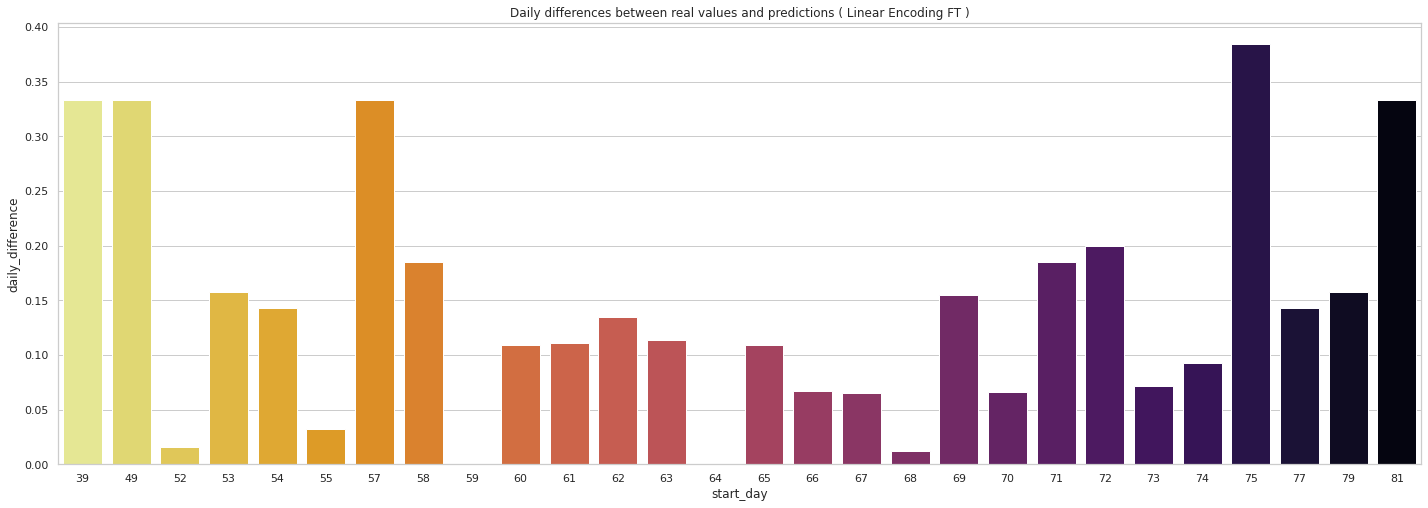

In [104]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [105]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.011412,2.708290,3.412262
Transformer - Periodic Encoding,-0.011412,2.708404,3.413103
LightGBM,0.659466,0.892986,1.979970


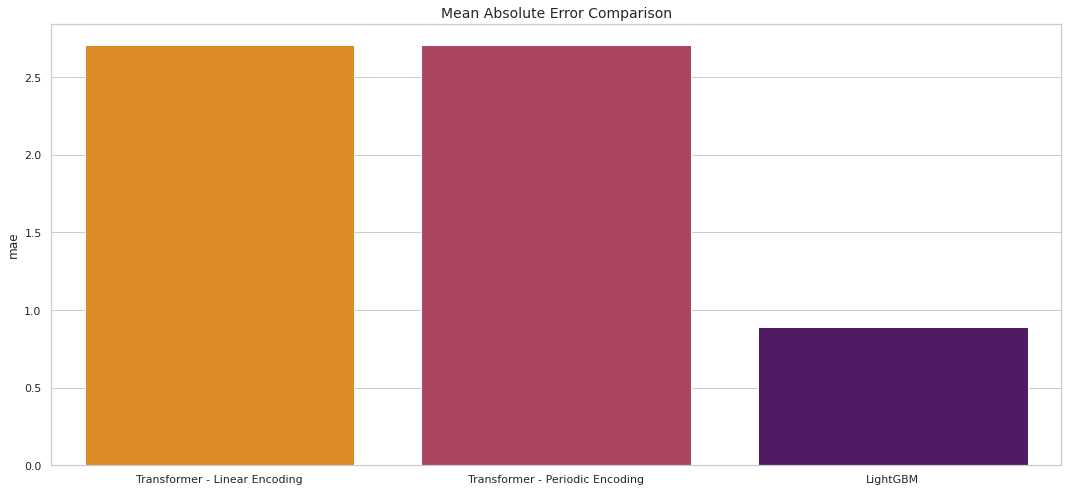

In [106]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


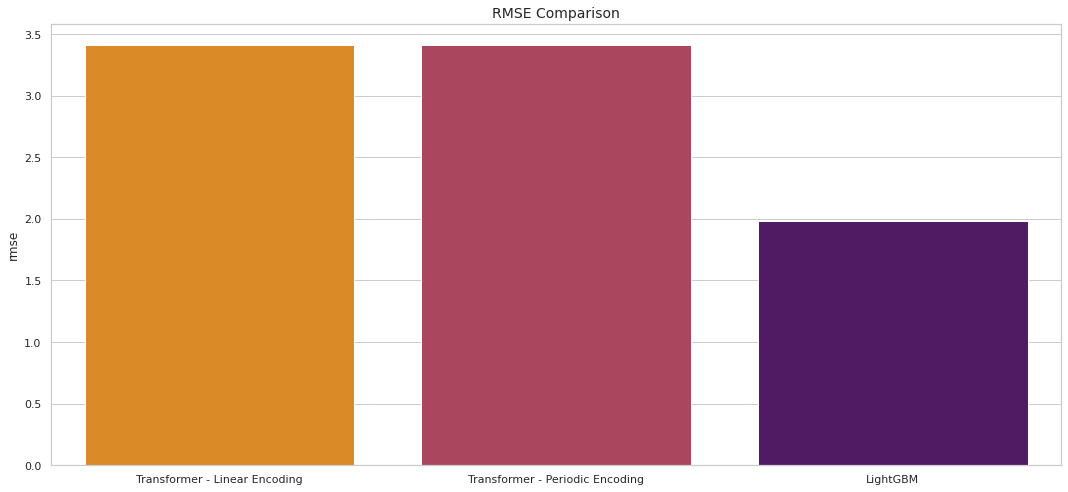

In [107]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


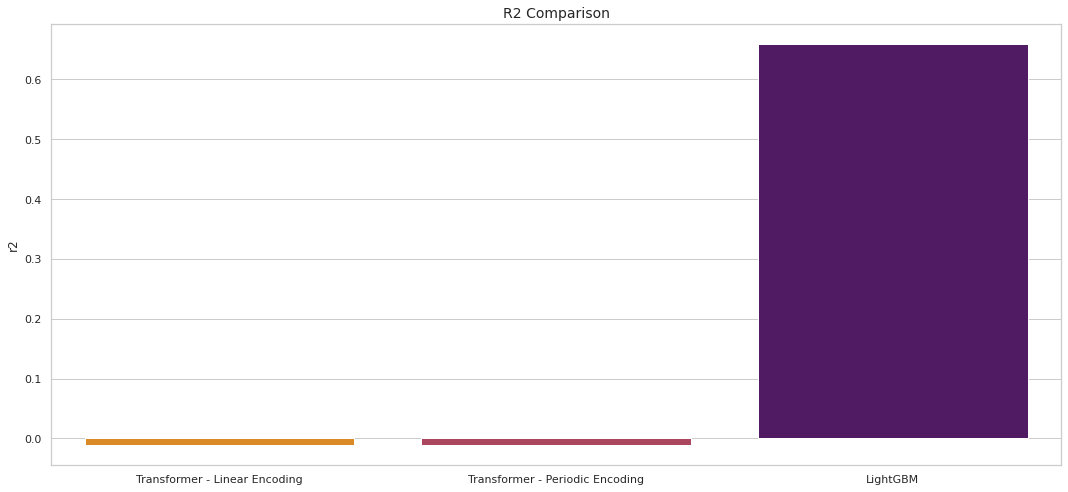

In [108]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [109]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.009282,2.708410,3.408666
Transformer - Periodic Encoding TUNED,-0.008578,2.708464,3.407477
LightGBM TUNED,0.671683,1.104848,1.944129


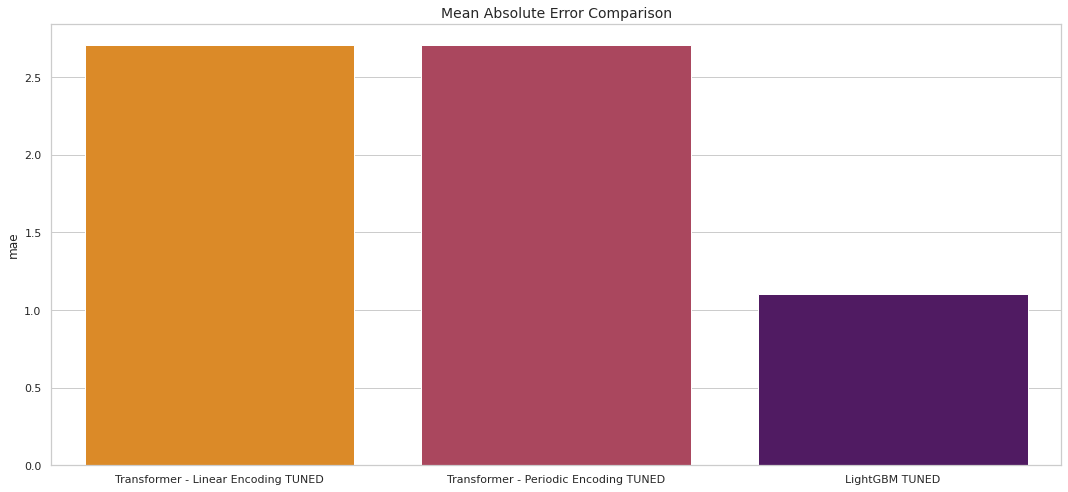

In [110]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


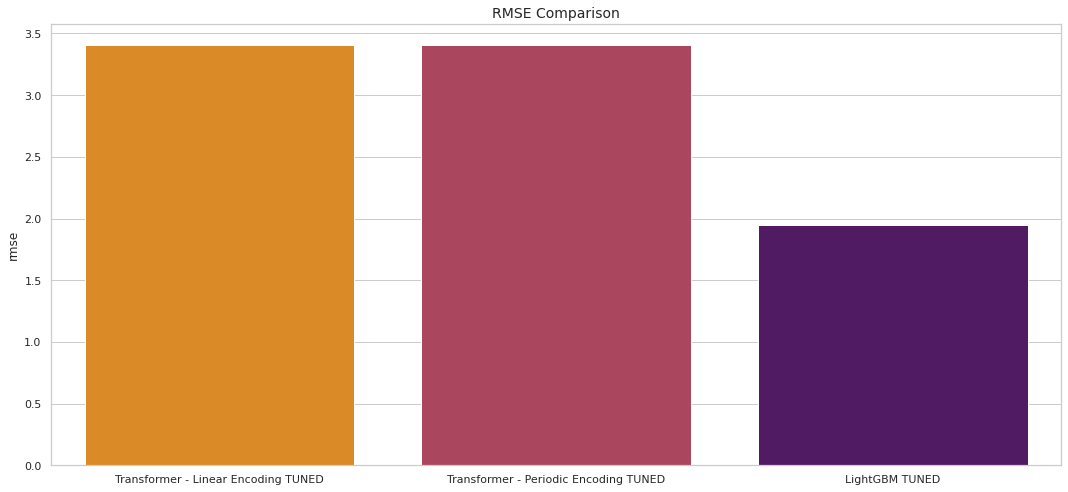

In [111]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


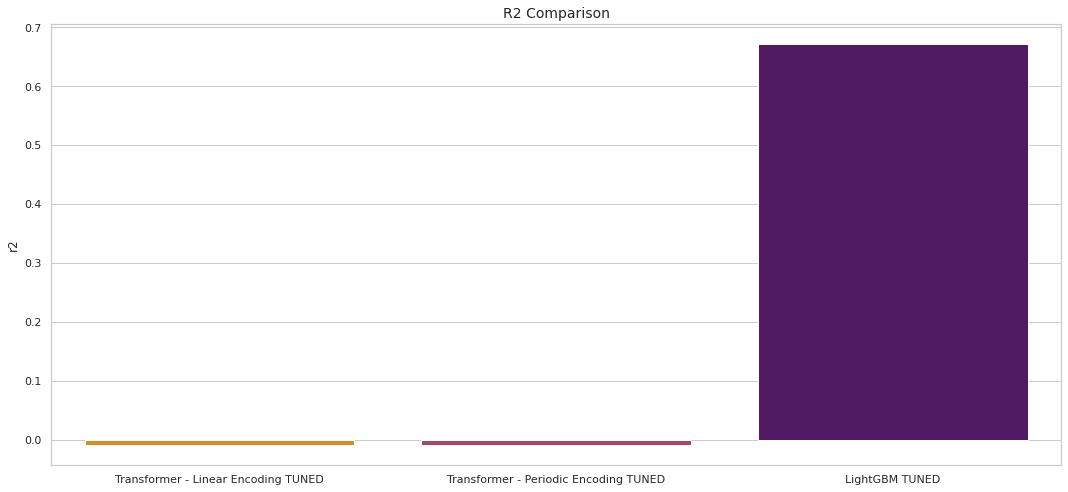

In [112]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
